In [1]:
# Imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import pickle
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

from utils import slide_window, extract_features_single, add_heat,\
                  draw_boxes, find_cars, read_img, draw_labelled_bboxes

from IPython.core import debugger

In [34]:
# To save as normal python script (easier to git diff)
# !jupyter nbconvert --to script pipeline.ipynb

[NbConvertApp] Converting notebook pipeline.ipynb to script
[NbConvertApp] Writing 4548 bytes to pipeline.py


In [3]:
# Load test images (RGB)
test_image_paths = glob.glob('test_images/test*.jpg')
test_images = [read_img(file, 'cv2') for file in test_image_paths]

In [4]:
PLOT = True
SAVE = False

In [5]:
svc = pickle.load(open('svc_classifier.pkl', 'rb'))
config = pickle.load(open('feature_config.pkl', 'rb'))
X_scaler = pickle.load(open('x_scaler.pkl', 'rb'))

In [6]:
x_start_stop = [None, None]
y_start_stop = [400, 700]
xy_window = (64, 64)
xy_overlap = (0.75, 0.75)

window_sizes = [
    (64, 64),
    (96, 96),
    (128, 128),
]

cells_per_window = int(xy_window[0] / config['pix_per_cell'])
cells_per_step = int((1 - xy_overlap[0]) * cells_per_window)

scales = [ws[0]/xy_window[0] for ws in window_sizes]

In [7]:
def search_windows(img, windows, clf, scaler, config):
    on_windows = []
    for window in windows:
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        features = extract_features_single(window_img, **config)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)

        if prediction == 1:
            on_windows.append(window)

    return on_windows

# DEPRACATED - using HOG subsampling for efficiency
if False:
    draw_image = np.copy(test_img)
    windows = []
    for size in window_sizes:
        windows.extend(slide_window(test_img,
                           x_start_stop=[None, None],
                           y_start_stop=[400, 700],
                           xy_window=(96, 96),
                           xy_overlap=(0.75, 0.75)))

    hot_windows = search_windows(test_img, windows, svc, X_scaler, config)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

    plt.imshow(test_img)
    plt.figure()
    plt.imshow(window_img)

In [24]:
test_img = test_images[0]

In [32]:
def pipeline(img):
    """
    1. Loop through the different scale windows and keep those which the
       classifier positively identifies as cars
    2. Create a thresholded heatmap from the overlapping windows
    3. Label the heatmap to identify distinct vehicles
    4. Draw labelled boxes from the heatmap
    """
    draw_img = np.copy(img)
    
    # 1. Identify "hot" windows
    hot_windows = []
    for scale in scales:
        hot_windows.extend(find_cars(test_img, y_start_stop=y_start_stop, scale=scale,
                                     svc=svc, X_scaler=X_scaler, **config))
    window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)
    
    
    # 2. Thresholded heatmap
    heatmap = np.zeros_like(test_img[:,:,0]).astype(np.float)
    add_heat(heatmap, hot_windows)

    threshold_heatmap = np.copy(heatmap)
    threshold_heatmap[threshold_heatmap <= 2] = 0

    # TODO - could be cool to overlay the heatmap on the image, or have something
    # which shows that the heat is about to go blue. Could do the bounding box
    # color based on the heatmap number (so higher heatmaps are emphasised)
    
    # 3. Label the heatmap
    labelled_array, num_features = label(threshold_heatmap)
    
    # 4. Draw the bounded boxes
    output = draw_labelled_bboxes(test_img, (labelled_array, num_features), color=(0, 0, 255), thick=6)


    if PLOT:
        images = [
            (window_img, 'All positive windows'),
            (heatmap, 'Heatmap'),
            (threshold_heatmap, 'Thresholded Heatmap'),
            (labelled_array, 'Labelled array'),
            (output, 'Result'),
        ]

        for i, title in images:
            plt.figure()
            plt.imshow(i)
            plt.title(title)
            if SAVE:
                fig = plt.gcf()
                fig.savefig('output_images/' + "_".join(t for t in title.split(" ")) + '.jpg')

    return draw_img

/Users/robertmoss/Code/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


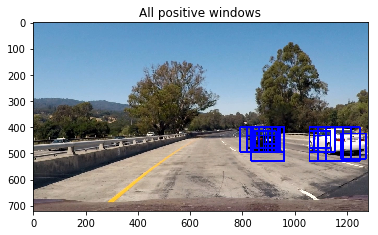

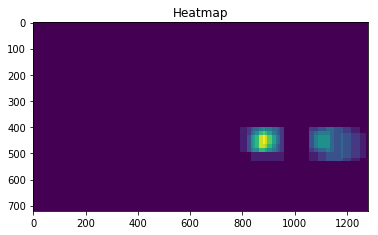

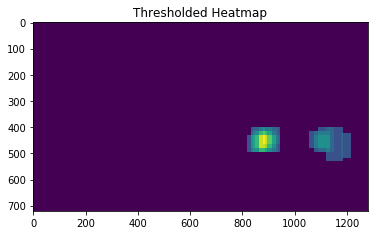

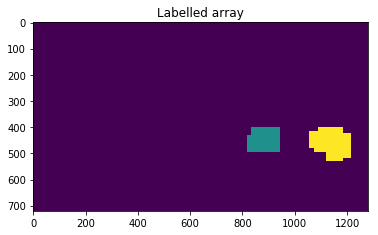

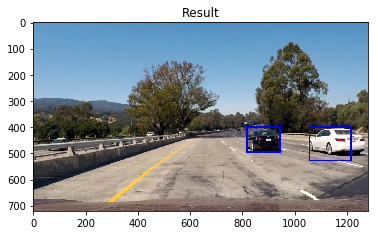

In [33]:
output = pipeline(test_img)